<a href="https://colab.research.google.com/github/Crismerlyn/br-edu-dropout-ml/blob/main/br_dropout_eda_to_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modeling the Dropout Crisis in Brazilian Basic Education**
The persistent challenge of school dropout represents a major impediment to social and economic development in Brazil. High dropout rates not only lead to individual loss of opportunity but also place significant strain on public education resources. This project leverages the comprehensive data from the Brazilian Basic Education Census to perform an advanced predictive analysis of this critical issue.  


**By Crismerlyn Paiva Pereira**   
**GitHub Repository**  
**Data Science Institute @ Brown University**


---


### **Objective**
The primary objective of this study is two-fold, combining technical rigor with practical policy relevance:


1.   **To Develop a Dual-Stage Predictive Model**: To create a sophisticated machine learning algorithm capable of accurately analyzing and forecasting the school dropout phenomenon. This involves using a Zero-Inflated modeling approach where the first stage classifies schools into 'Zero Dropout' versus 'Non-Zero Dropout,' and the second stage uses regression to quantify the rate for schools with positive evasion.
2.   **To Empower Targeted Public Policies**: The ultimate goal is to equip the government with advanced analytical insights necessary to inform and promote targeted public policies. By identifying the structural, demographic, and institutional factors that drive both the incidence and the severity of evasion, this work aims to enable the government to deploy resources more efficiently and effectively to mitigate the dropout crisis.

### **Methodology**

This project follows a structured methodology composed of four main phases:


1.   Exploratory Data Analysis (EDA) and Feature Engineering
2.   Data Preparation and Preprocessing
3.   Model Development
4.   Evaluation and Interpretation

### **Dataset Documentation**
- Brazilian Federal Government Website
  - [School performance dataset](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/indicadores-educacionais/taxas-de-rendimento-escolar)
  - [School microdata dataset](https://www.gov.br/inep/pt-br/acesso-a-informacao/dados-abertos/microdados/censo-escolar)
- [Dataset Dictionary](https://docs.google.com/spreadsheets/d/1VtY0JADri3nPbbyOMM5yK-9SVotOHxgf/edit?gid=954659642#gid=954659642)
- [Feature Engineering](https://docs.google.com/drawings/d/1OVmby3B1H8LJxws-3xGpOpYt-o6rNGEPBJN8YkNsgwo/edit?usp=sharing)

## Packages and Installations

In [83]:
# !pip install openpyxl

In [84]:
from google.colab import drive
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Reading datasets

In [85]:
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Classes/1030: Hands on Data Science/Final Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# Performance Data - dataset with dropout rate
df_rates = pd.read_excel(
        base_path + 'tx_rend_escolas_2024.xlsx',
        sheet_name='ESCOLAS'
    )

In [87]:
########## FILTERING ##########
# Excluding pass and fail rates
df_rates_filtered = df_rates[['school_ID','total_elementary_dropout_rate','total_hs_dropout_rate']]

In [88]:
########## GENERATING TARGET VARIABLE ##########
# The original dataset has the elementary dropout rate and high school dropout rate
# For this project we will use the mean of these dropout rates as target variable

df_rates_filtered = df_rates_filtered.replace('--', pd.NA)
df_rates_filtered['mean_dropout_rate'] = df_rates_filtered[['total_elementary_dropout_rate', 'total_hs_dropout_rate']].mean(axis=1)
df_rates_filtered['mean_dropout_rate'] = pd.to_numeric(df_rates_filtered['mean_dropout_rate'], errors='coerce')

# selecting only relevant columns
df_rates_final = df_rates_filtered[['school_ID','mean_dropout_rate']]

In [89]:
# School microdata - dataset with school features
df_features = pd.read_csv(
        base_path + 'microdados_ed_basica_2024.csv',
        sep=';',
        encoding='latin-1'
    )

/tmp/ipython-input-2494810504.py:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_features = pd.read_csv(


In [90]:
########## FILTERING ##########
# Columns to be excluded:
#   - names
#   - unique identifiers

# names
df_features_filtered = df_features.drop(columns=['NO_REGIAO','NO_UF','NO_MUNICIPIO','NO_REGIAO_GEOG_INTERM','NO_REGIAO_GEOG_IMED','NO_MESORREGIAO','NO_MICRORREGIAO','NO_DISTRITO','NO_ENTIDADE'])

# unique identifiers
df_features_filtered = df_features_filtered.drop(columns=['NU_CNPJ_ESCOLA_PRIVADA','NU_CNPJ_MANTENEDORA','DS_ENDERECO','NU_ENDERECO','DS_COMPLEMENTO','NO_BAIRRO','CO_CEP','NU_DDD','NU_TELEFONE','NU_ANO_CENSO'])

In [91]:
########## GENERATING FINAL DATASET ##########

# joining the dataframes to pick only rows that can be related between both
df_merged = pd.merge(df_features_filtered, df_rates_final, left_on='CO_ENTIDADE', right_on='school_ID', how='inner')
df_merged = df_merged[df_merged['mean_dropout_rate'].notna()]

# excluding school unique identifier
df_final = df_merged.drop(columns=['school_ID','CO_ENTIDADE'])

In [92]:
print(f'The initial dataset shape is {df_final.shape}')

The initial dataset shape is (126704, 407)


## General Variables

In [93]:
# Graph Pattern
GRAPH_TITLE_SIZE = 13
GRAPH_LABEL_SIZE = 10
FIG_SIZE = (10, 6)
GREEN_COLOR = 'darkgreen'
BLUE_COLOR = 'blue'
YELLOW_COLOR = 'yellow'
RED_COLOR = 'red'
EDGE_COLOR = 'black'
LIGHT_GREEN_COLOR = 'lightgreen'

# Dataset
TARGET = 'mean_dropout_rate'

## Exploratory Data Analysis


### Target variable: mean_dropout_rate

In [94]:
########## EXPLORING DATA ##########
df_final[TARGET].describe(include='all', percentiles=[0.05, 0.25, 0.5, 0.65, 0.7, 0.75, 0.95])

,mean_dropout_rate
count,126704.000000
mean,1.032975
std,3.221268
min,0.000000
5%,0.000000
25%,0.000000
50%,0.000000
65%,0.000000
70%,0.300000
75%,0.600000


In [95]:
zero_count = len(df_final[df_final[TARGET] == 0])
total_count = len(df_final)
percent_zero = (zero_count / total_count) * 100

print(f"Number of schools with a mean dropout rate of 0%: {zero_count}")
print(f"Percentage of schools with a mean dropout rate of 0%: {percent_zero:.2f}%")

Number of schools with a mean dropout rate of 0%: 85411
Percentage of schools with a mean dropout rate of 0%: 67.41%


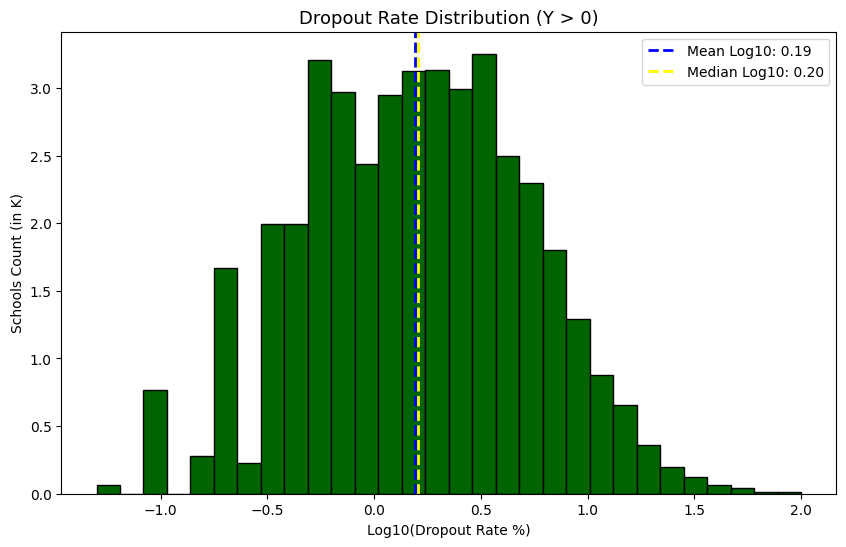

In [96]:
########## VISUALIZING DATA ##########
# Since the number of zeros is a huge percentage, I will plot only positive values in order to better visualization of the distribution

data_positive = df_final[df_final[TARGET] > 0][TARGET]

# log distribution to better visualization
data_log = np.log10(data_positive)

mean_log = data_log.mean()
median_log = data_log.median()

plt.figure(figsize=FIG_SIZE)

counts, bins, patches = plt.hist(
    data_log,
    bins=30,
    color=GREEN_COLOR,
    edgecolor=EDGE_COLOR
)

plt.clf()

bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.bar(
    bin_centers,
    counts / 1000,
    width=np.diff(bins),
    color=GREEN_COLOR,
    edgecolor=EDGE_COLOR
)


plt.axvline(
    mean_log,
    color=BLUE_COLOR,
    linestyle='--',
    linewidth=2,
    label=f'Mean Log10: {mean_log:.2f}'
)

plt.axvline(
    median_log,
    color=YELLOW_COLOR,
    linestyle='--',
    linewidth=2,
    label=f'Median Log10: {median_log:.2f}'
)

plt.title(f'Dropout Rate Distribution (Y > 0)', fontsize=GRAPH_TITLE_SIZE)
plt.xlabel('Log10(Dropout Rate %)', fontsize=GRAPH_LABEL_SIZE)
plt.ylabel(f'Schools Count (in K)', fontsize=GRAPH_LABEL_SIZE)
plt.legend()
plt.show()

### How many students dropped out of school in 2024?
Why is this topic important?

In [97]:
# sum number of enrollment
enrollment = df_final['QT_MAT_BAS'].fillna(0) + df_final['QT_MAT_MED'].fillna(0)

# decimal drop out rate
dropout_rate_decimal = df_final[TARGET] / 100

# number of students
students_round = round(enrollment * dropout_rate_decimal)
total_students = students_round.sum()


print(f"Estimated total number of students that dropped out school in 2024: {total_students:,}")
print(f"Mean dropout number per school: {students_round.mean():.2f}")

Estimated total number of students that dropped out school in 2024: 676,002.0
Mean dropout number per school: 5.34


### Exploring 407 features

In [98]:
########## GATHERING DATA INFO ##########
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126704 entries, 0 to 128095
Columns: 407 entries, CO_REGIAO to mean_dropout_rate
dtypes: float64(392), int64(11), object(4)
memory usage: 394.4+ MB


------------------------------------------------------------
/t Type count /n
float64    392
int64       11
object       4
Name: count, dtype: int64


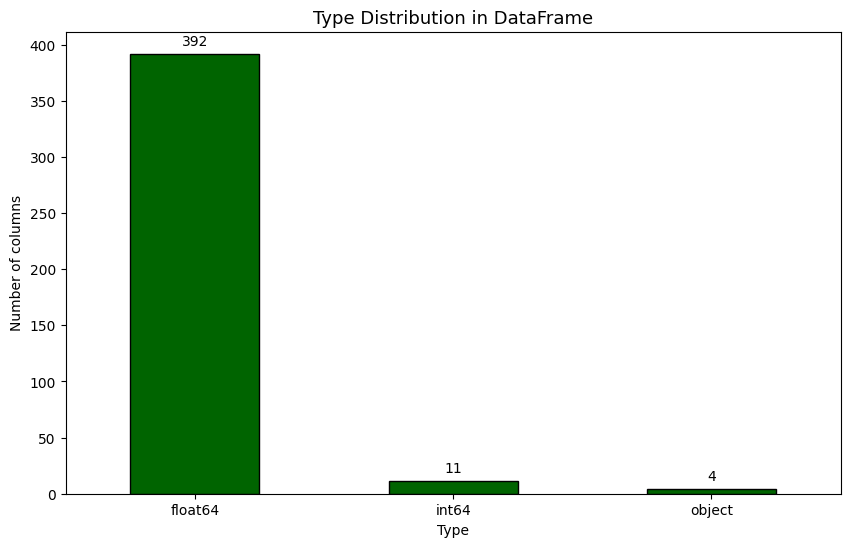

In [99]:
########## VERIFYING DATA TYPE DISTRIBUTION ##########
dtype_counts = df_final.dtypes.value_counts()

print('-' * 60)
print("/t Type count /n")
print(dtype_counts)

plt.figure(figsize=FIG_SIZE)

dtype_counts.plot(kind='bar', color=GREEN_COLOR, edgecolor=EDGE_COLOR)

plt.title('Type Distribution in DataFrame', fontsize=GRAPH_TITLE_SIZE)
plt.xlabel('Type', fontsize=GRAPH_LABEL_SIZE)
plt.ylabel('Number of columns', fontsize=GRAPH_LABEL_SIZE)
plt.xticks(rotation=360)
for i, count in enumerate(dtype_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=GRAPH_LABEL_SIZE)
plt.show()

In [100]:
########## EXPLORING OBJECT TYPE COLUMNS ##########
object_columns = df_final.select_dtypes(include=['object']).columns.tolist()

for col in object_columns:
    print('-' * 60)
    print(f'Feture: {col}')
    num_unique = df_final[col].nunique()
    print(f"Unique values: {num_unique}\n")

    print("Top 10 Frequent Values:")
    print(df_final[col].value_counts(dropna=False).head(10))
    print("\n")

------------------------------------------------------------
Feture: SG_UF
Unique values: 27

Top 10 Frequent Values:
SG_UF
SP    15987
BA    12791
MG    10365
MA     9550
PA     9314
RJ     7868
PE     6793
PR     5958
CE     5843
RS     5749
Name: count, dtype: int64


------------------------------------------------------------
Feture: CO_ORGAO_REGIONAL
Unique values: 312

Top 10 Frequent Values:
CO_ORGAO_REGIONAL
1.0     6188
2.0     5973
3.0     5222
NaN     4556
4.0     4550
5.0     4527
6.0     4313
9.0     4066
8.0     3839
10.0    3634
Name: count, dtype: int64


------------------------------------------------------------
Feture: DT_ANO_LETIVO_INICIO
Unique values: 175

Top 10 Frequent Values:
DT_ANO_LETIVO_INICIO
05FEB2024:00:00:00    33759
15FEB2024:00:00:00    20508
19FEB2024:00:00:00    16884
29JAN2024:00:00:00     7722
01FEB2024:00:00:00     6395
04MAR2024:00:00:00     5936
22JAN2024:00:00:00     4332
26FEB2024:00:00:00     4293
06FEB2024:00:00:00     3601
07FEB2024:00:0

In [101]:
# Accordingly to the dataset documentation and with the distribution above, the variables below should be dates
df_final['DT_ANO_LETIVO_INICIO'] = pd.to_datetime(df_final['DT_ANO_LETIVO_INICIO'], errors='coerce', format='%d%b%Y:%H:%M:%S')
df_final['DT_ANO_LETIVO_TERMINO'] = pd.to_datetime(df_final['DT_ANO_LETIVO_TERMINO'], errors='coerce', format='%d%b%Y:%H:%M:%S')

# Accordingly to the dataset documentation and with the distribution above, the variables below should be varchar size 2. The similar type in pandas should be category, as this feature represents the states and there is exactly 27 states
df_final['SG_UF'] = df_final['SG_UF'].astype('category')

# The CO_ORGAO_REGIONAL feature is a unique identifier of 5 characters, that's why must remain as an string

print('-' * 12 + ' Dataset columns after casting ' + '-' * 12 + '\n')
display(df_final[['DT_ANO_LETIVO_INICIO','DT_ANO_LETIVO_TERMINO','SG_UF']].head())

------------ Dataset columns after casting ------------



,DT_ANO_LETIVO_INICIO,DT_ANO_LETIVO_TERMINO,SG_UF
0,2024-02-12,2024-12-13,RO
1,2024-02-08,2024-12-14,RO
2,2024-02-09,2024-12-14,RO
3,2024-02-08,2024-12-14,RO
4,2024-02-09,2024-12-16,RO


In [102]:
########## BOOLEAN COLUMNS IDENTIFICATION ##########
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
nunique_counts = df_final[numeric_cols].nunique(dropna=True)
binary_candidate_cols = nunique_counts[nunique_counts == 2].index.tolist()

print(f"Number of eligible columns to boolean type: {len(binary_candidate_cols)}")

binary_flags_list = []

for col in binary_candidate_cols:
    unique_values = df_final[col].dropna().unique()
    unique_values.sort()

    is_binary_flag = (len(unique_values) == 2 and
                      (unique_values[0] == 0 or unique_values[0] == 0.0) and
                      (unique_values[1] == 1 or unique_values[1] == 1.0))

    if is_binary_flag:
        binary_flags_list.append(col)

print(f"Number of Flags/Binary columns: {len(binary_flags_list)}")

# Casting to boolean
for col in binary_flags_list:
    df_final[col] = df_final[col].astype('boolean')

Number of eligible columns to boolean type: 205
Number of Flags/Binary columns: 204


In [103]:
########## CATEGORICAL COLUMNS IDENTIFICATION ##########

# Exploring others numeric columns in order to find potential categorical features
all_numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
nunique_counts = df_final[[col for col in all_numeric_cols]].nunique(dropna=True)

# Looking to the documentantion, the maximum number of categories that a column can have is 8, that's why we will take a look only on columns with 8 or less unique values
low_cardinality_cols = nunique_counts[
    (nunique_counts >= 3) & (nunique_counts <= 8)
].sort_values(ascending=False).index.tolist()

print(f"Eligible columns to categorical type: {len(low_cardinality_cols)} \n")

for col in low_cardinality_cols:
    print('-' * 20)
    print(f"{col} - Cardinality: {df_final[col].nunique(dropna=True)}")
    print(df_final[col].value_counts(dropna=False))

Eligible columns to categorical type: 31 

--------------------
QT_PROF_NUTRICIONISTA - Cardinality: 8
QT_PROF_NUTRICIONISTA
0.0        102527
1.0         22471
2.0          1361
3.0           318
4.0            13
5.0             7
88888.0         6
10.0            1
Name: count, dtype: int64
--------------------
QT_PROF_FONAUDIOLOGO - Cardinality: 7
QT_PROF_FONAUDIOLOGO
0.0        123190
1.0          3395
2.0           109
3.0             4
88888.0         3
5.0             2
4.0             1
Name: count, dtype: int64
--------------------
QT_PROF_REVISOR_BRAILLE - Cardinality: 6
QT_PROF_REVISOR_BRAILLE
0.0        126007
1.0           649
2.0            39
3.0             5
88888.0         2
4.0             2
Name: count, dtype: int64
--------------------
TP_REDE_LOCAL - Cardinality: 5
TP_REDE_LOCAL
3.0    55641
2.0    24038
9.0    19513
1.0    19225
0.0     8287
Name: count, dtype: int64
--------------------
CO_REGIAO - Cardinality: 5
CO_REGIAO
2    48573
3    36295
1    19309
4    

In [104]:
# Looking into the prefixes to find patterns in the documentation
column_prefixes = [col[:3] for col in low_cardinality_cols]
pd.Series(column_prefixes).value_counts()

,count
IN_,16
TP_,11
QT_,3
CO_,1


In [105]:
# Columns that starts with CO_ are unique identifiers therefore not categoricals
# Columns that starts with QT_ represents quantities therefore not categoricals
# Columns that starts with TP_ represents type therefore categoricals
# Columns that starts with IN_ represents infraestructure therefore can be boolean that means has that infraestructure or not, or categorical that means has the infraestructure or not or there is another phase for this infraestructure e.g N/A

# Casting the columns
changed_cols = []
for col in low_cardinality_cols:
    if col.startswith('TP_'):
        df_final[col] = df_final[col].astype('category')
        changed_cols.append(col)
    if col.startswith('IN_'):
        df_final[col] = df_final[col].astype('category')
        changed_cols.append(col)

print('-' * 5 + ' Categorical Columns ' + '-' * 5 + '\n')
print(f"Number of columns changed: {len(changed_cols)}\n")
print(changed_cols)

print('\n' + '-' * 5 + ' Dataframe View ' + '-' * 5 + '\n')
print(df_final[changed_cols].head(5))

----- Categorical Columns -----

Number of columns changed: 27

['TP_REDE_LOCAL', 'TP_RESPONSAVEL_REGULAMENTACAO', 'TP_LOCALIZACAO_DIFERENCIADA', 'TP_CATEGORIA_ESCOLA_PRIVADA', 'TP_DEPENDENCIA', 'TP_OCUPACAO_GALPAO', 'TP_PROPOSTA_PEDAGOGICA', 'TP_REGULAMENTACAO', 'TP_OCUPACAO_PREDIO_ESCOLAR', 'IN_TRATAMENTO_LIXO_SEPARACAO', 'TP_PODER_PUBLICO_PARCERIA', 'IN_ACES_INTERNET_DISP_PESSOAIS', 'IN_ACESSO_INTERNET_COMPUTADOR', 'IN_TRATAMENTO_LIXO_INEXISTENTE', 'IN_TRATAMENTO_LIXO_RECICLAGEM', 'IN_TRATAMENTO_LIXO_REUTILIZA', 'TP_INDIGENA_LINGUA', 'IN_REDES_SOCIAIS', 'IN_EXAME_SELECAO', 'IN_ESPACO_ATIVIDADE', 'IN_ESPACO_EQUIPAMENTO', 'IN_EDUC_AMB_CONTEUDO', 'IN_EDUC_AMB_CURRICULAR', 'IN_EDUC_AMB_EIXO', 'IN_EDUC_AMB_EVENTOS', 'IN_EDUC_AMB_PROJETOS', 'IN_EDUC_AMB_NENHUMA']

----- Dataframe View -----

  TP_REDE_LOCAL TP_RESPONSAVEL_REGULAMENTACAO TP_LOCALIZACAO_DIFERENCIADA  \
0           9.0                           2.0                         2.0   
1           1.0                           3.0 

In [106]:
########## VERIFYING NEW DATA TYPE DISTRIBUTION ##########
dtype_counts = df_final.dtypes.value_counts()
print('-' * 5 + "Type count" + '-' * 5 + '\n')
print(dtype_counts)

-----Type count-----

boolean           204
float64           162
category           16
int64              10
category            3
datetime64[ns]      2
category            1
category            1
category            1
object              1
category            1
category            1
category            1
category            1
category            1
category            1
Name: count, dtype: int64


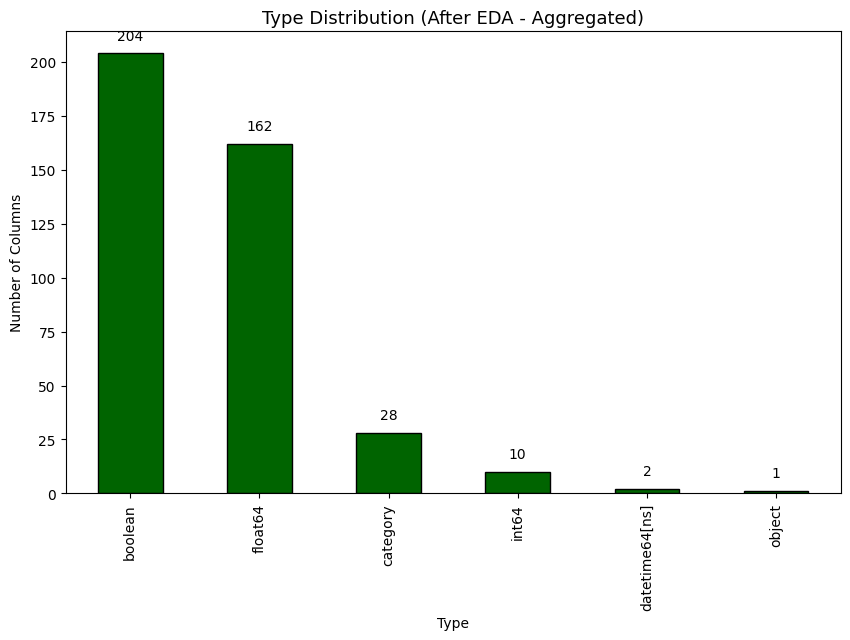

In [107]:
########## VISUALIZING NEW DATA TYPE DISTRIBUTION ##########
dtype_counts_original = df_final.dtypes.value_counts()

category_count = dtype_counts_original[dtype_counts_original.index.astype(str).str.startswith('category')].sum()

aggregated_counts_dict = {}

for dtype, count in dtype_counts_original.items():
    if str(dtype).startswith('category'):
        if 'category' not in aggregated_counts_dict:
            aggregated_counts_dict['category'] = category_count
    else:
        aggregated_counts_dict[str(dtype)] = count


dtype_counts_aggregated = pd.Series(aggregated_counts_dict)
desired_order = ['boolean', 'category', 'float64', 'int64', 'object', 'datetime64[ns]']

dtype_counts_aggregated = dtype_counts_aggregated.reindex(desired_order, fill_value=0).sort_values(ascending=False)


plt.figure(figsize=FIG_SIZE)
bars = dtype_counts_aggregated.plot(kind='bar', color=GREEN_COLOR, edgecolor=EDGE_COLOR, ax=plt.gca())

plt.title('Type Distribution (After EDA - Aggregated)', fontsize=GRAPH_TITLE_SIZE)
plt.xlabel('Type', fontsize=GRAPH_LABEL_SIZE)
plt.ylabel('Number of Columns', fontsize=GRAPH_LABEL_SIZE)

for i, count in enumerate(dtype_counts_aggregated):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=GRAPH_LABEL_SIZE)

plt.show()

In [108]:
########## REMOVING UNIQUE VALUES FOR ALL DATA POINTS ##########
unique_values_cols = df_final.columns[df_final.nunique() == 1].tolist()
df_final = df_final.drop(columns=unique_values_cols, errors='raise')
print(f"Number of excluded columns: {len(unique_values_cols)}")
print("Excluded columns:")
for col in unique_values_cols:
    print(f"- {col}")

print('\n Final dataset shape:')
print(df_final.shape)

Number of excluded columns: 3
Excluded columns:
- TP_SITUACAO_FUNCIONAMENTO
- IN_REGULAR
- IN_ESCOLARIZACAO

 Final dataset shape:
(126704, 404)


In [109]:
########## REMOVING REDUNDANT COLUMNS ##########
# Some quantitatives columns represents the quantity of some boolean infraestructure columns, for this reason, these variables presents some redundance. e.g exists_sound_equipment is true and qtt_sound_equipment = 30, every time that qtt_sound_equipment > 0, exists_sound_equipment is true.
# Let's verify this below

eq_columns = {}

for col_qt in [c for c in df_final.columns.tolist() if c.startswith('QT_')]:
    sufix = col_qt[3:]
    col_in = 'IN_' + sufix

    if col_in in df_final.columns.tolist():
        eq_columns[col_in] = col_qt


verification = {}
for col_in, col_qt in eq_columns.items():
    in_col = df_final[col_in]
    qt_col = df_final[col_qt]

    in_col = (in_col == True).astype(int)
    qt_boolean = (qt_col > 0).astype(int)

    match_pctg = ((in_col == qt_boolean).sum() / len(df_final))

    verification[col_in] = match_pctg

exclude_eq_cols = []

for col_in, result in verification.items():
    col_qt = eq_columns[col_in]

    if isinstance(result, float):
      if result == 1:
          exclude_eq_cols.append(col_in)


print(f"The following {len(exclude_eq_cols)} columns with the prefix 'IN_' demonstrated 100% match with respective columns with the prefix 'QT_' and can be excluded:\n")
for col in exclude_eq_cols:
    print(f"- {col}")

The following 26 columns with the prefix 'IN_' demonstrated 100% match with respective columns with the prefix 'QT_' and can be excluded:

- IN_EQUIP_DVD
- IN_EQUIP_SOM
- IN_EQUIP_TV
- IN_EQUIP_LOUSA_DIGITAL
- IN_EQUIP_MULTIMIDIA
- IN_DESKTOP_ALUNO
- IN_COMP_PORTATIL_ALUNO
- IN_TABLET_ALUNO
- IN_PROF_ADMINISTRATIVOS
- IN_PROF_SERVICOS_GERAIS
- IN_PROF_BIBLIOTECARIO
- IN_PROF_SAUDE
- IN_PROF_COORDENADOR
- IN_PROF_FONAUDIOLOGO
- IN_PROF_NUTRICIONISTA
- IN_PROF_PSICOLOGO
- IN_PROF_ALIMENTACAO
- IN_PROF_PEDAGOGIA
- IN_PROF_SECRETARIO
- IN_PROF_SEGURANCA
- IN_PROF_MONITORES
- IN_PROF_GESTAO
- IN_PROF_ASSIST_SOCIAL
- IN_PROF_TRAD_LIBRAS
- IN_PROF_AGRICOLA
- IN_PROF_REVISOR_BRAILLE


In [110]:
df_final = df_final.drop(columns=exclude_eq_cols)
print(f'Final dataset shape:')
print(df_final.shape)

Final dataset shape:
(126704, 378)


In [111]:
# general print
print('-' * 15 + ' Dataset Head ' + '-' * 15 + '\n')
print(df_final.head(), '\n')

# general information
print('-' * 15 + ' Dataset Info ' + '-' * 15 + '\n')
df_final.info(verbose=False, memory_usage='deep')

--------------- Dataset Head ---------------

   CO_REGIAO SG_UF  CO_UF  CO_MUNICIPIO  CO_REGIAO_GEOG_INTERM  \
0          1    RO     11       1100015                   1102   
1          1    RO     11       1100015                   1102   
2          1    RO     11       1100015                   1102   
3          1    RO     11       1100015                   1102   
4          1    RO     11       1100015                   1102   

   CO_REGIAO_GEOG_IMED  CO_MESORREGIAO  CO_MICRORREGIAO  CO_DISTRITO  \
0               110005               2                6    110001505   
1               110005               2                6    110001505   
2               110005               2                6    110001505   
3               110005               2                6    110001505   
4               110005               2                6    110001505   

  TP_DEPENDENCIA  ... QT_TUR_BAS_N  QT_TUR_BAS_EAD QT_TUR_INF_INT  \
0              2  ...          0.0             0.0     

In [112]:
########## MISSING VALUES ##########
missing_count = df_final.isnull().sum()
print("Top 20 Columns with Missing Values:")
print(missing_count.sort_values(ascending=False).head(20))

print(f"\nTotal NaN values in dataset: {missing_count.sum():,}")

Top 20 Columns with Missing Values:
CO_LINGUA_INDIGENA_3              126565
IN_FORMA_CONT_ES_TERMO_COLAB      126488
IN_FORMA_CONT_ES_TERMO_FOMENTO    126488
IN_FORMA_CONT_ES_ACORDO_COOP      126488
IN_FORMA_CONT_ES_PREST_SERV       126488
IN_FORMA_CONT_ES_COOP_TEC_FIN     126488
IN_FORMA_CONT_ES_CONSORCIO_PUB    126488
CO_IES_OFERTANTE                  126347
CO_LINGUA_INDIGENA_2              126343
IN_FORMA_CONT_MU_CONSORCIO_PUB    125645
IN_FORMA_CONT_MU_COOP_TEC_FIN     125645
IN_FORMA_CONT_MU_ACORDO_COOP      125645
IN_FORMA_CONT_MU_TERMO_FOMENTO    125645
IN_FORMA_CONT_MU_TERMO_COLAB      125645
IN_FORMA_CONT_MU_PREST_SERV       125645
IN_FORMA_CONT_CONSORCIO_PUB       125450
IN_FORMA_CONT_PRESTACAO_SERV      125450
TP_PODER_PUBLICO_PARCERIA         125450
IN_FORMA_CONT_TERMO_COLABORA      125450
IN_FORMA_CONT_TERMO_FOMENTO       125450
dtype: int64

Total NaN values in dataset: 4,940,273


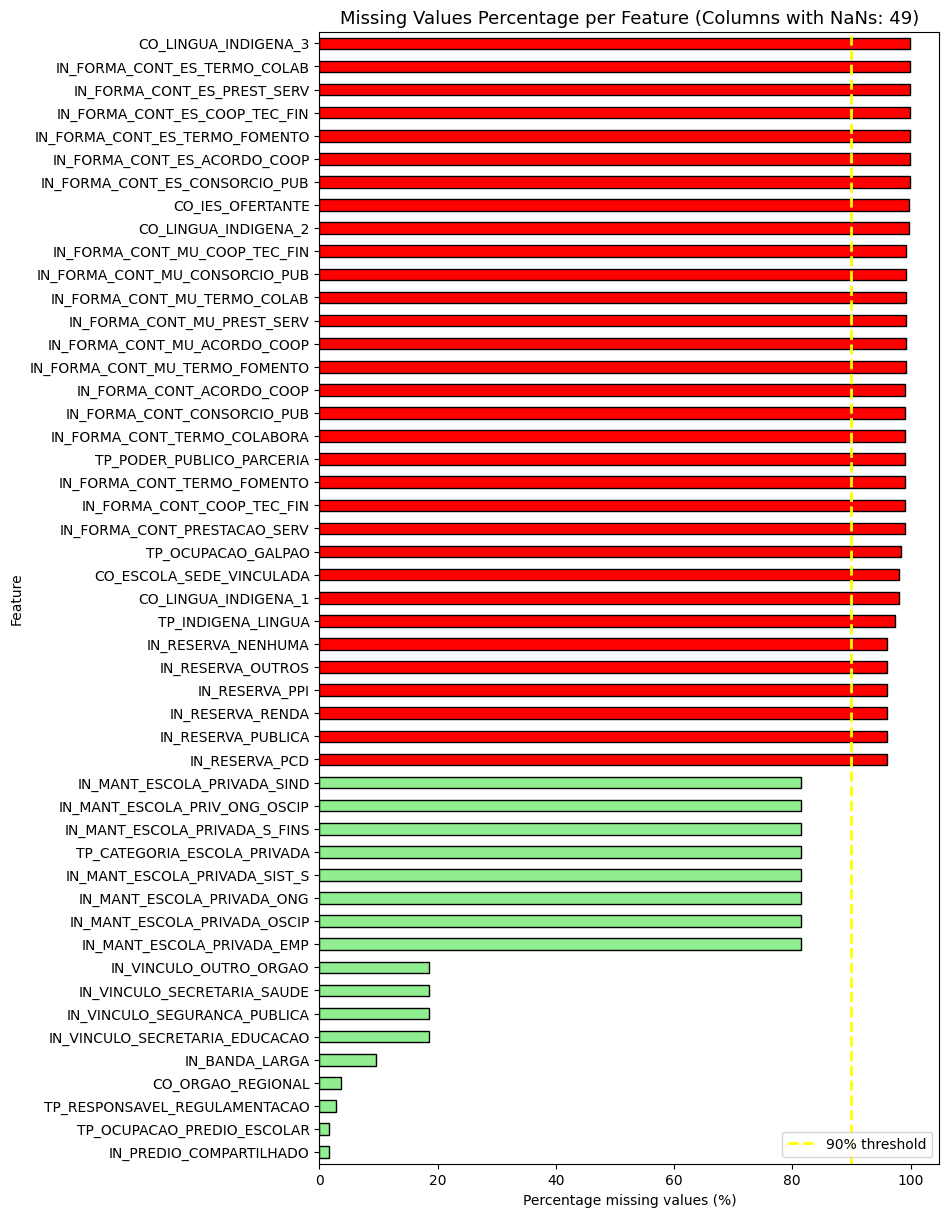

In [113]:
# From the two previous commands is clear that some features almost reach 100% of null values, let's explore these features
THRESHOLD = 90

null_percentages = (df_final.isnull().sum() / len(df_final)) * 100

missing_data_series = null_percentages[null_percentages > 0].sort_values(ascending=True)

# plotting columns with missing values
plot_data = missing_data_series
plt.figure(figsize=(8, len(plot_data) * 0.3))

bar_colors = ['red' if p > THRESHOLD else LIGHT_GREEN_COLOR for p in plot_data]
plot_data.plot(kind='barh', color=bar_colors, edgecolor=EDGE_COLOR, ax=plt.gca())
plt.axvline(
    THRESHOLD,
    color=YELLOW_COLOR,
    linestyle='--',
    linewidth=2,
    label=f'{THRESHOLD}% threshold'
)
plt.title(f'Missing Values Percentage per Feature (Columns with NaNs: {len(missing_data_series)})', fontsize=GRAPH_TITLE_SIZE)
plt.xlabel('Percentage missing values (%)', fontsize=GRAPH_LABEL_SIZE)
plt.ylabel('Feature', fontsize=GRAPH_LABEL_SIZE)
plt.legend(loc='lower right')
plt.show()

In [114]:
columns_to_drop = missing_data_series[missing_data_series > THRESHOLD].index.tolist()
df_final = df_final.drop(columns=columns_to_drop)

print('-' * 60)
print('\t Feature Exclusion Due Missing Values \n')

print(f'> {len(columns_to_drop)} features were excluded due to more than {THRESHOLD}% missing values')
print(f'> Number of features with null values remaining: {df_final.isnull().sum().astype(bool).sum()}\n')
print(f'Final shape: {df_final.shape}')
print('-' * 60)

------------------------------------------------------------
	 Feature Exclusion Due Missing Values 

> 32 features were excluded due to more than 90% missing values
> Number of features with null values remaining: 17

Final shape: (126704, 346)
------------------------------------------------------------


#### Some features against target variable based on feature engineering grouping

Plot Functions

In [115]:
def plot_bar_mean_dropout_by_category(df, feature_col, title, xlabel, mapping=None, target_col=TARGET, title_size=GRAPH_TITLE_SIZE, label_size=GRAPH_LABEL_SIZE, edge_color=EDGE_COLOR,bar_color=GREEN_COLOR,mean_color=YELLOW_COLOR, fig_size=FIG_SIZE):

    if mapping:
        grouped_data = df.groupby(df[feature_col].map(mapping))[target_col].agg(['mean']).reset_index()
    else:
        grouped_data = df.groupby(feature_col)[target_col].agg(['mean']).reset_index()


    grouped_data = grouped_data.sort_values(by='mean', ascending=False)

    plt.figure(figsize=fig_size)

    plt.bar(
        grouped_data[feature_col],
        grouped_data['mean'],
        capsize=4,
        color=bar_color,
        edgecolor=edge_color
    )
    plt.title(title, fontsize=title_size)
    plt.xlabel(xlabel, fontsize=label_size)
    plt.ylabel(f'Mean dropout rate', fontsize=label_size)

    plt.axhline(df[target_col].mean(), color=mean_color, linestyle='-', linewidth=1.5, label=f'National Mean: {df[target_col].mean():.2f}%')

    plt.legend()
    plt.tight_layout()
    plt.show()

In [116]:
def plot_delta_mean_by_flag(df, flag_cols, plot_labels, title, ylabel, fig_size=FIG_SIZE, target_col=TARGET, negative_color=LIGHT_GREEN_COLOR, positive_color=RED_COLOR, edge_color=EDGE_COLOR, title_size=GRAPH_TITLE_SIZE, label_size=GRAPH_LABEL_SIZE):
    impact_delta = {}

    for col in flag_cols:
        current_data = df_final[[col, target_col]].dropna()
        mean_by_group = current_data.groupby(current_data[col].astype(float)).mean()[target_col]
        impact_delta[col] = mean_by_group.loc[1.0] - mean_by_group.loc[0.0]

    impact_series = pd.Series(impact_delta)

    label_map = dict(zip(flag_cols, plot_labels))
    impact_series.index = impact_series.index.map(label_map)

    impact_series = impact_series.sort_values(ascending=True)

    plt.figure(figsize=fig_size)

    colors = [positive_color if x > 0 else negative_color for x in impact_series]

    plt.barh(
        impact_series.index,
        impact_series.values,
        color=colors,
        edgecolor=edge_color
    )

    plt.axvline(0, color='gray', linestyle='--', linewidth=1)

    plt.title(title, fontsize=title_size)
    plt.xlabel('Difference in Mean Dropout Rate (Present - Absent)', fontsize=label_size)
    plt.ylabel(ylabel, fontsize=label_size)

    plt.tight_layout()
    plt.show()

In [117]:
def plot_violin_by_category(df, feature_col, title, xlabel, category_order=None, category_codes=None, max_target_val=None, target_col=TARGET, fig_size=FIG_SIZE, label_size=GRAPH_LABEL_SIZE, title_size=GRAPH_TITLE_SIZE, mean_line_color=YELLOW_COLOR, violin_color=GREEN_COLOR):

    plot_data = [
        df_final[df_final[feature_col] == code][target_col]
        for code in category_codes
    ]

    plt.figure(figsize=fig_size)

    violins = plt.violinplot(
        plot_data,
        vert=True,
        showextrema=False
    )

    for pc in violins['bodies']:
        pc.set_facecolor(violin_color)

    plt.ylim(-0.5, max_target_val)
    plt.xticks(np.arange(1, len(category_order) + 1), category_order, fontsize=label_size)

    plt.title(title, fontsize=title_size)
    plt.xlabel(xlabel, fontsize=label_size)
    plt.ylabel(f'Dropout Rate (%) (Capped at {max_target_val}%)', fontsize=label_size)

    plt.axhline(
        df_final[target_col].mean(),
        color=mean_line_color,
        label=f'National Mean: {df_final[target_col].mean():.2f}%'
    )
    plt.legend()
    plt.show()

In [118]:
def plot_hexbin_with_dropout(df, feature_col, title, xlabel, max_feature_val=1000, max_target_val=100, target_col=TARGET, fig_size=FIG_SIZE, title_size=GRAPH_TITLE_SIZE, label_size=GRAPH_LABEL_SIZE):

    plot_df = df[
        (df[feature_col] <= max_feature_val) &
        (df[target_col] <= max_target_val)
    ].copy()

    plt.figure(figsize=fig_size)

    hb = plt.hexbin(
        plot_df[feature_col],
        plot_df[target_col],
        gridsize=30,
        mincnt=1,
        cmap='YlGn_r'
    )

    cb = plt.colorbar(hb)
    cb.set_label('Count of Schools in Bin')

    plt.title(title, fontsize=title_size)
    plt.ylabel(f'Dropout Rate (Capped at {max_target_val}%)', fontsize=label_size)
    plt.xlabel(f'{xlabel} (Capped at {max_feature_val})', fontsize=label_size)
    plt.grid(axis='y', alpha=0.5)

    plt.tight_layout()
    plt.show()

Group **Identification, Location, and Institutional Ties**

/tmp/ipython-input-4279270156.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(feature_col)[target_col].agg(['mean']).reset_index()


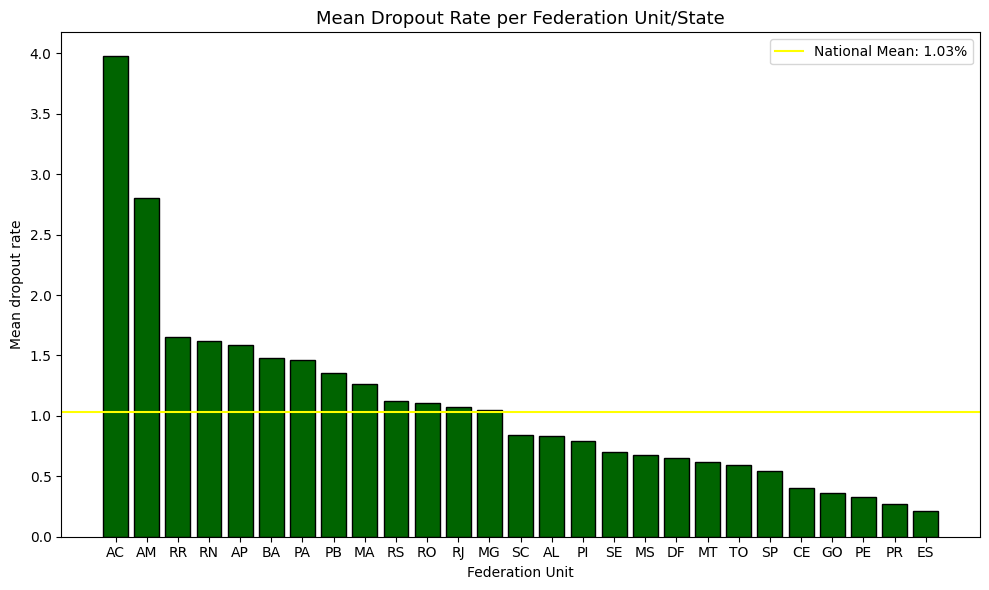

In [119]:
# per Federation Unit/State
plot_bar_mean_dropout_by_category(
    df_final,
    'SG_UF',
    'Mean Dropout Rate per Federation Unit/State',
    'Federation Unit'
)

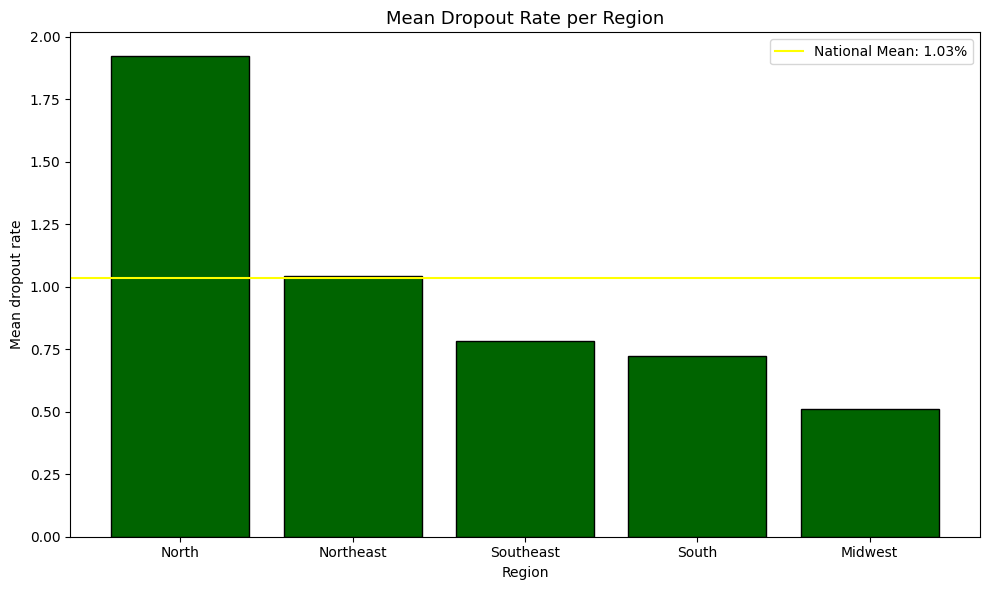

In [120]:
# Per region
plot_bar_mean_dropout_by_category(
    df_final,
    'CO_REGIAO',
    'Mean Dropout Rate per Region',
    'Region',
    mapping = {
    1: 'North',
    2: 'Northeast',
    3: 'Southeast',
    4: 'South',
    5: 'Midwest'
}
)

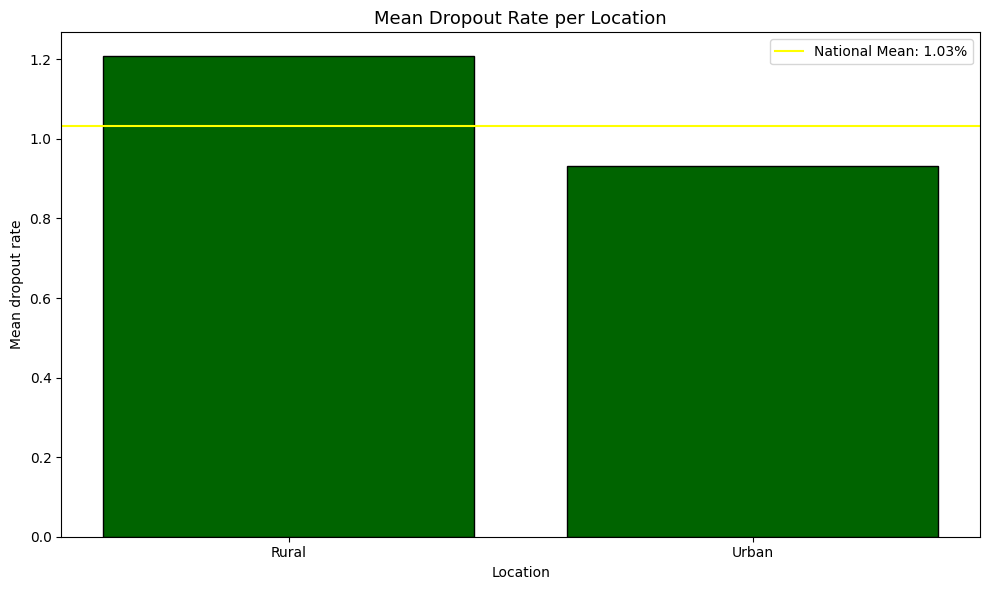

In [121]:
# Per zone (Urban vs Rural)
plot_bar_mean_dropout_by_category(
    df_final,
    'TP_LOCALIZACAO',
    'Mean Dropout Rate per Location',
    'Location',
    mapping = {
    1: 'Urban',
    2: 'Rural'
}
)

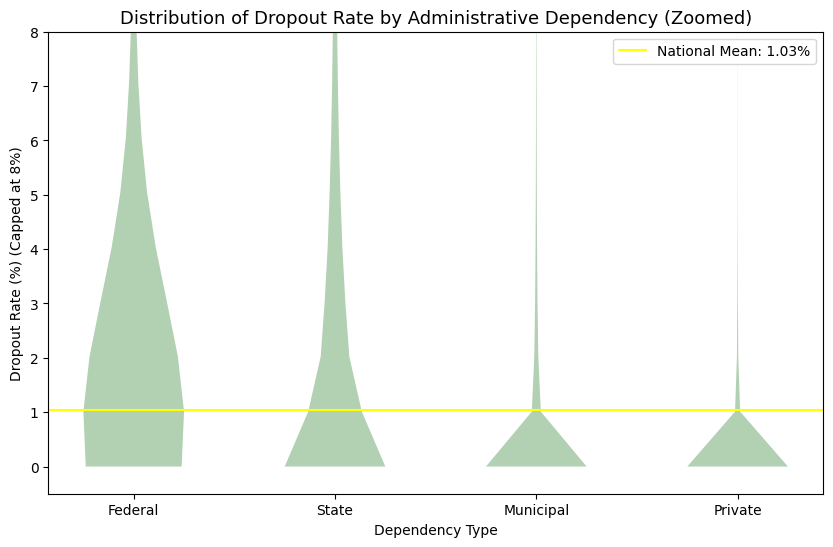

In [122]:
# Per Administrative Dependency
dependency_order = ['Federal', 'State', 'Municipal', 'Private']
dependency_codes = [1, 2, 3, 4]

plot_violin_by_category(
    df_final,
    'TP_DEPENDENCIA',
    'Distribution of Dropout Rate by Administrative Dependency (Zoomed)',
    'Dependency Type',
    category_order=dependency_order,
    category_codes=dependency_codes,
    max_target_val=8 # Capping at 8% for better visualization
)

Group **Infrastructure, Equipment, and Accessibility**

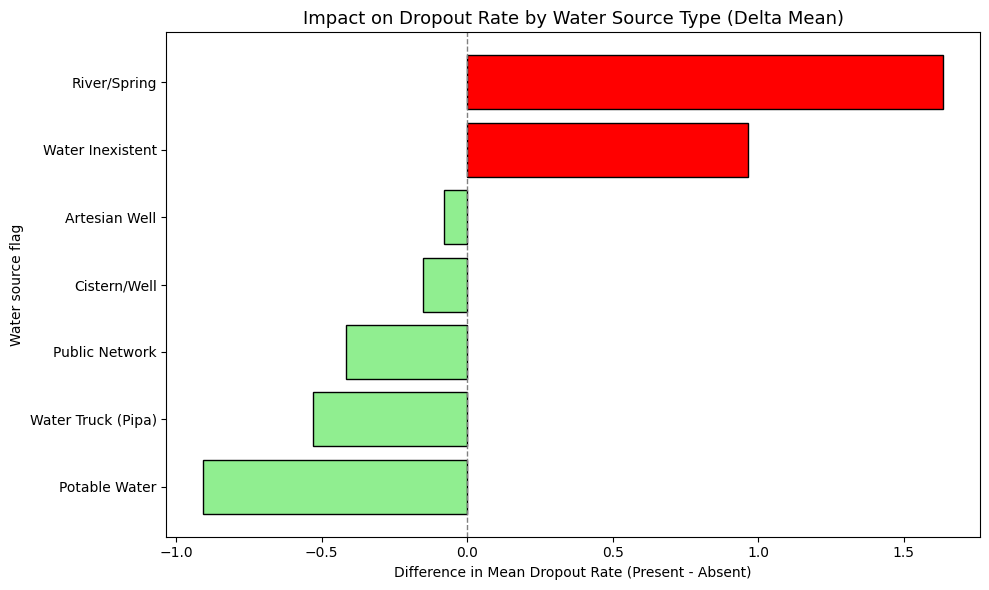

In [123]:
water_flags = [
    'IN_AGUA_POTAVEL',
    'IN_AGUA_REDE_PUBLICA',
    'IN_AGUA_POCO_ARTESIANO',
    'IN_AGUA_CACIMBA',
    'IN_AGUA_FONTE_RIO',
    'IN_AGUA_INEXISTENTE',
    'IN_AGUA_CARRO_PIPA'
]


water_labels = [
    'Potable Water',
    'Public Network',
    'Artesian Well',
    'Cistern/Well',
    'River/Spring',
    'Water Inexistent',
    'Water Truck (Pipa)'
]

plot_delta_mean_by_flag(
    df_final,
    water_flags,
    water_labels,
    'Impact on Dropout Rate by Water Source Type (Delta Mean)',
    'Water source flag'
)

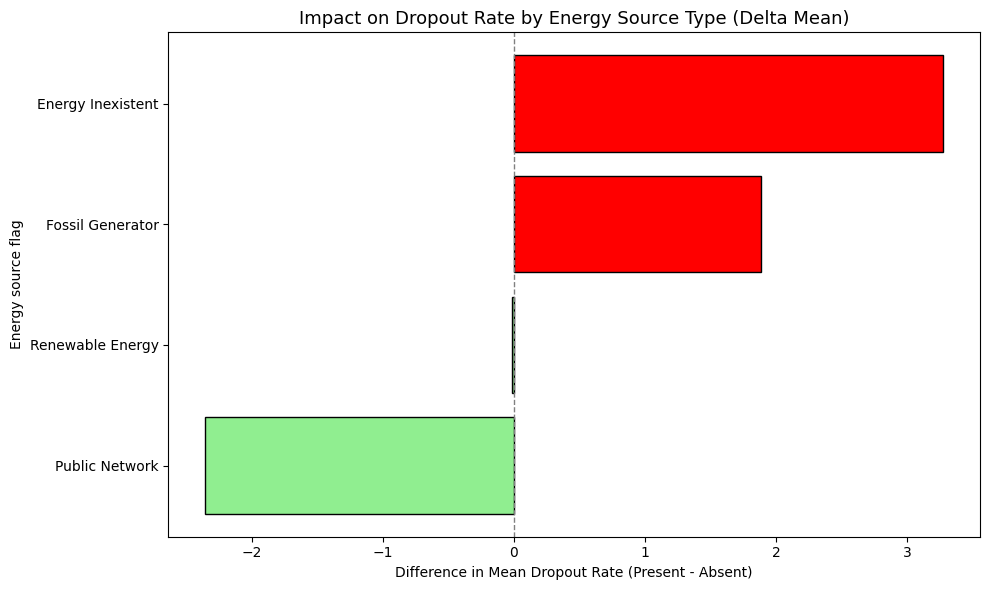

In [124]:
energy_flags = [
    'IN_ENERGIA_REDE_PUBLICA',
    'IN_ENERGIA_GERADOR_FOSSIL',
    'IN_ENERGIA_RENOVAVEL',
    'IN_ENERGIA_INEXISTENTE'
]

energy_labels = [
    'Public Network',
    'Fossil Generator',
    'Renewable Energy',
    'Energy Inexistent'
]

plot_delta_mean_by_flag(
    df_final,
    energy_flags,
    energy_labels,
    'Impact on Dropout Rate by Energy Source Type (Delta Mean)',
    'Energy source flag'
)

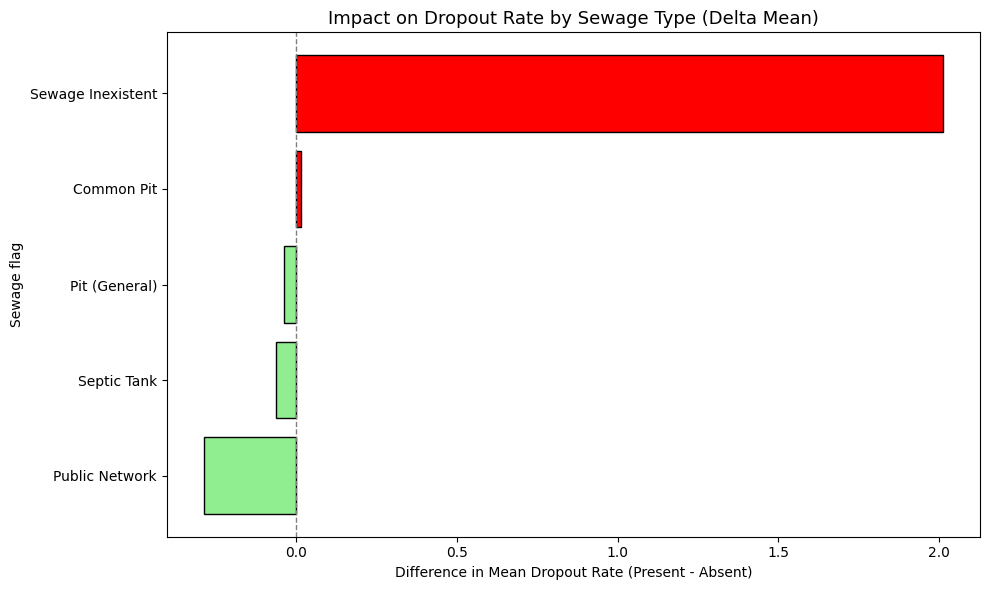

In [125]:
sewage_flags = [
    'IN_ESGOTO_REDE_PUBLICA',
    'IN_ESGOTO_FOSSA_SEPTICA',
    'IN_ESGOTO_FOSSA_COMUM',
    'IN_ESGOTO_FOSSA',
    'IN_ESGOTO_INEXISTENTE'
]

sewage_labels = [
    'Public Network',
    'Septic Tank',
    'Common Pit',
    'Pit (General)',
    'Sewage Inexistent'
]

plot_delta_mean_by_flag(
    df_final,
    sewage_flags,
    sewage_labels,
    'Impact on Dropout Rate by Sewage Type (Delta Mean)',
    'Sewage flag'
)

Group **Support Staff, Materials, and Indigenous Education**

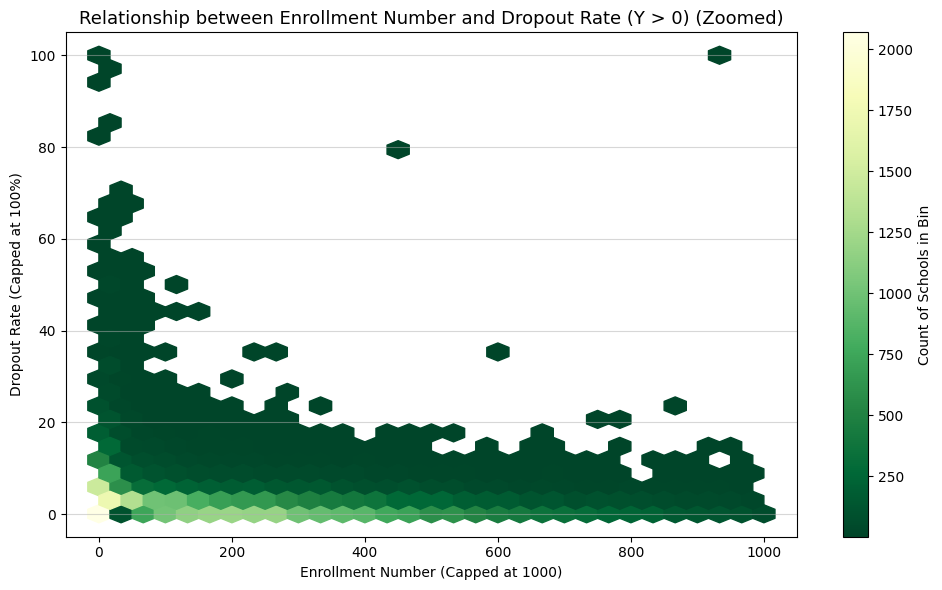

In [126]:
plot_hexbin_with_dropout(
  df_final[df_final['mean_dropout_rate'] > 0],
  'QT_MAT_FUND',
  'Relationship between Enrollment Number and Dropout Rate (Y > 0) (Zoomed)',
  'Enrollment Number'
)

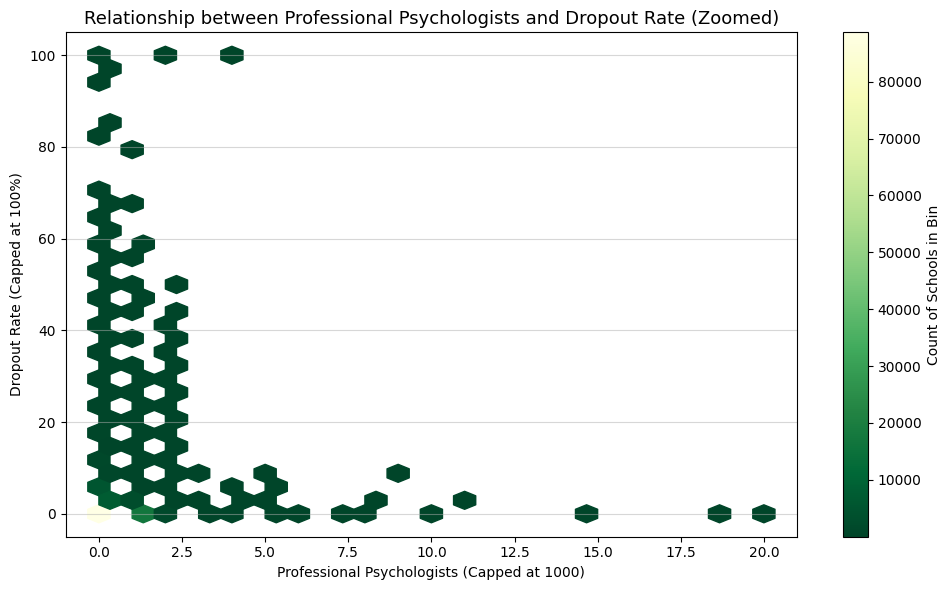

In [127]:
plot_hexbin_with_dropout(
  df_final,
  'QT_PROF_PSICOLOGO',
  'Relationship between Professional Psychologists and Dropout Rate (Zoomed)',
  'Professional Psychologists'
)

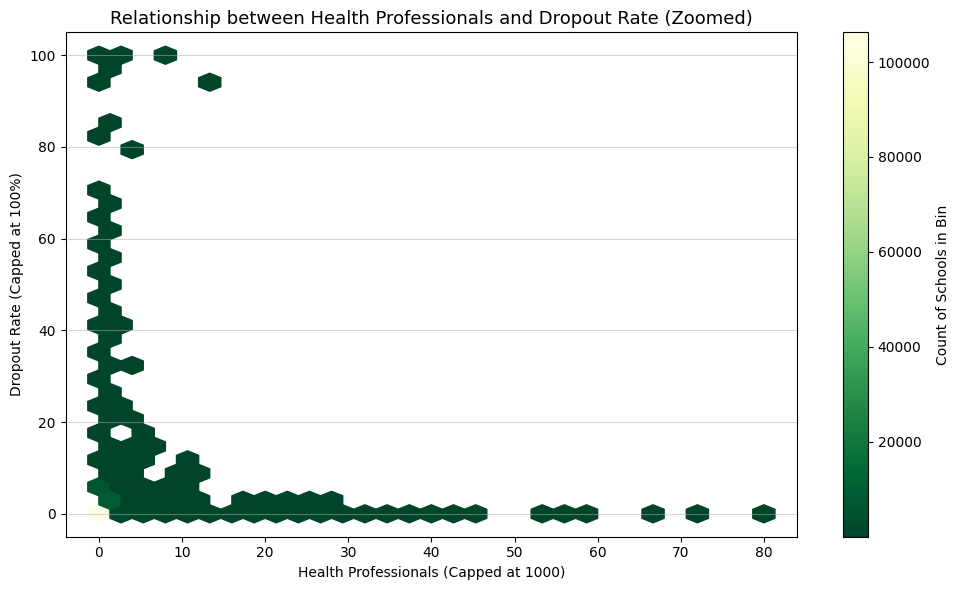

In [128]:
plot_hexbin_with_dropout(
  df_final,
  'QT_PROF_SAUDE',
  'Relationship between Health Professionals and Dropout Rate (Zoomed)',
  'Health Professionals'
)

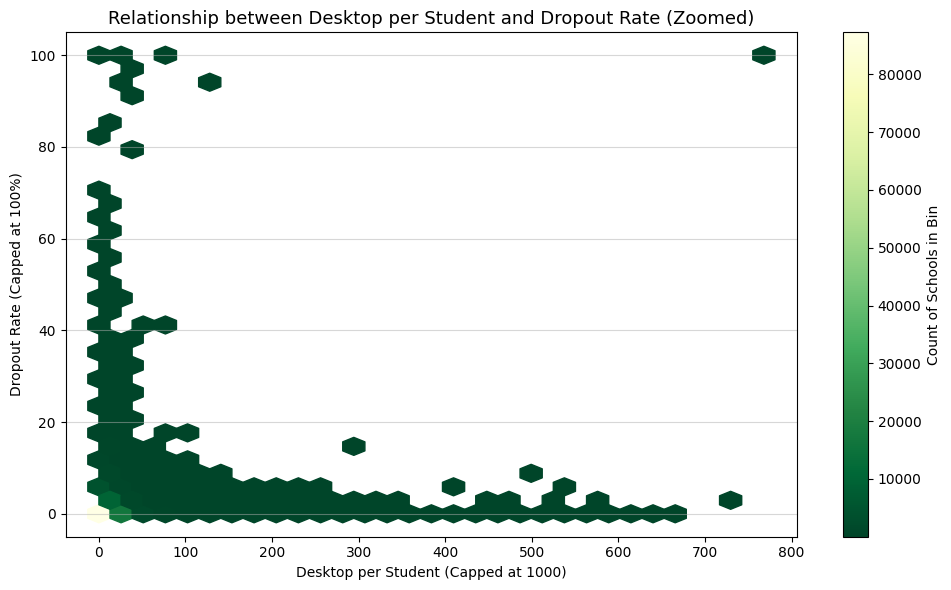

In [129]:
plot_hexbin_with_dropout(
  df_final,
  'QT_DESKTOP_ALUNO',
  'Relationship between Desktop per Student and Dropout Rate (Zoomed)',
  'Desktop per Student'
)

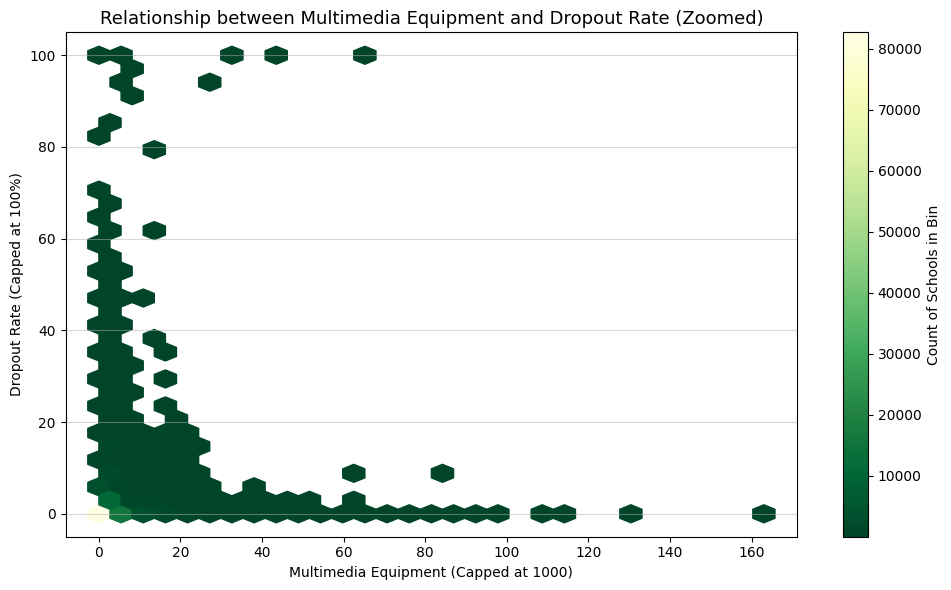

In [130]:
plot_hexbin_with_dropout(
  df_final,
  'QT_EQUIP_MULTIMIDIA',
  'Relationship between Multimedia Equipment and Dropout Rate (Zoomed)',
  'Multimedia Equipment'
)

Group **Management, Educational Offer, and Communication Means**

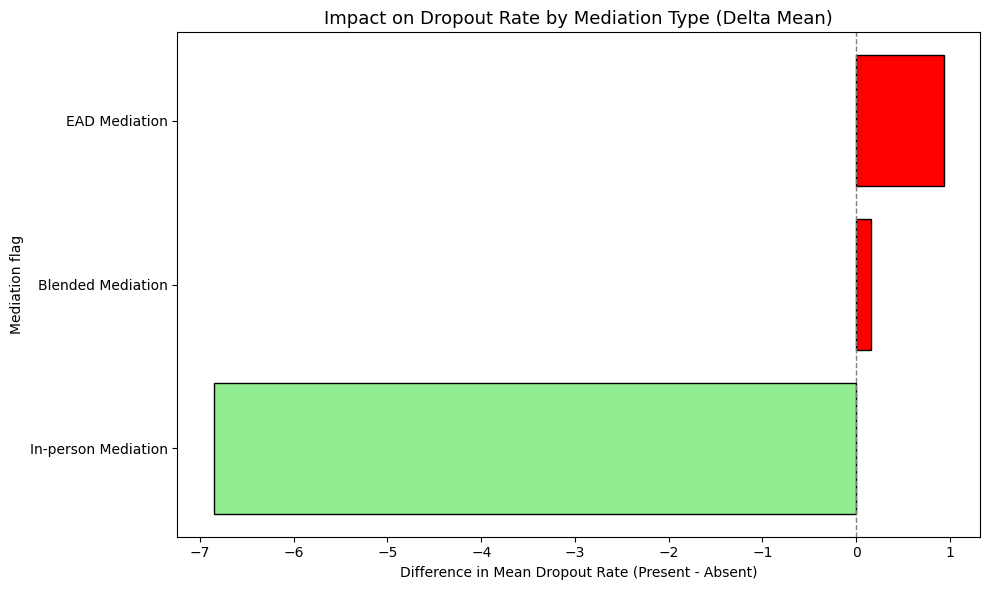

In [131]:
mediation_flags = [
        'IN_MEDIACAO_PRESENCIAL',
        'IN_MEDIACAO_SEMIPRESENCIAL',
        'IN_MEDIACAO_EAD'
]

mediation_labels = [
    'In-person Mediation',
    'Blended Mediation',
    'EAD Mediation'
]

plot_delta_mean_by_flag(
    df_final,
    mediation_flags,
    mediation_labels,
    'Impact on Dropout Rate by Mediation Type (Delta Mean)',
    'Mediation flag'
)

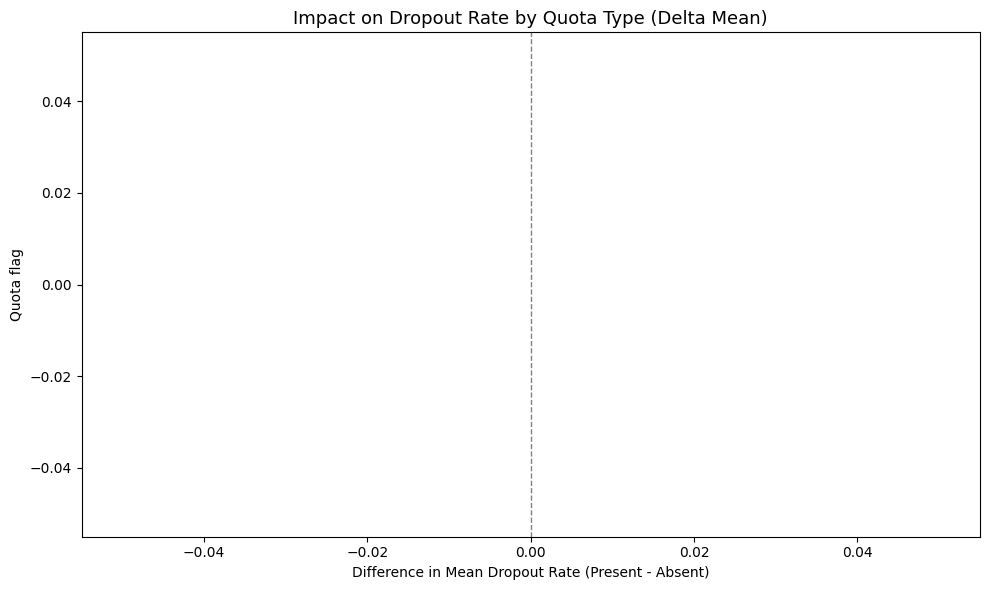

In [132]:
reservation_flags = [
    col for col in [
        'IN_RESERVA_PPI',
        'IN_RESERVA_RENDA',
        'IN_RESERVA_PUBLICA',
        'IN_RESERVA_PCD',
        'IN_RESERVA_OUTROS',
        'IN_RESERVA_NENHUMA'
    ] if col in df_final.columns
]

reservation_labels = [
    'Reserved for Indigenous/Black/Brown',
    'Reserved for Income',
    'Reserved for Public School',
    'Reserved for PwD',
    'Other Reservations',
    'No Reservation'
]

plot_delta_mean_by_flag(
    df_final,
    reservation_flags,
    reservation_labels,
    'Impact on Dropout Rate by Quota Type (Delta Mean)',
    'Quota flag'
)

Group **Enrollment Quantitative**

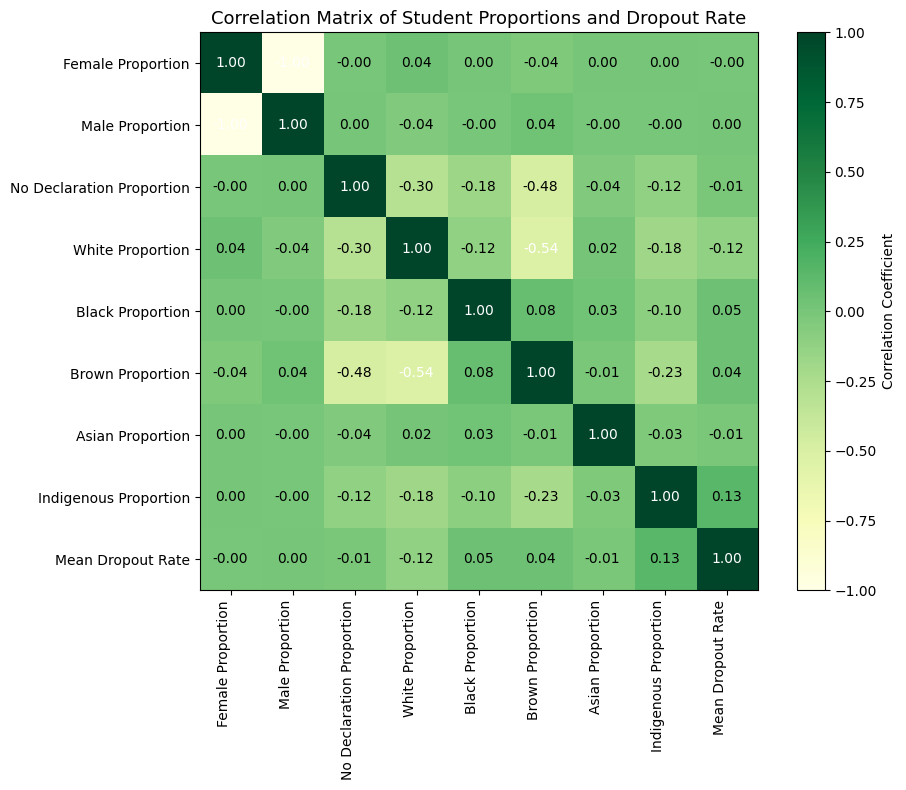

In [133]:
enrollment_cols = [
    'QT_MAT_BAS_FEM',
    'QT_MAT_BAS_MASC',
    'QT_MAT_BAS_ND',
    'QT_MAT_BAS_BRANCA',
    'QT_MAT_BAS_PRETA',
    'QT_MAT_BAS_PARDA',
    'QT_MAT_BAS_AMARELA',
    'QT_MAT_BAS_INDIGENA'
]

plot_labels = {
    'PROP_FEM': 'Female Proportion',
    'PROP_MASC': 'Male Proportion',
    'PROP_ND': 'No Declaration Proportion',
    'PROP_BRANCA': 'White Proportion',
    'PROP_PRETA': 'Black Proportion',
    'PROP_PARDA': 'Brown Proportion',
    'PROP_AMARELA': 'Asian Proportion',
    'PROP_INDIGENA': 'Indigenous Proportion',
    TARGET: 'Mean Dropout Rate'
}

df_temp = df_final[[TARGET] + enrollment_cols].copy()
df_temp['QT_MAT_BAS_TOTAL'] = df_temp[enrollment_cols].sum(axis=1)

proportion_cols = []

for col in enrollment_cols:
    new_col = col.replace('QT_MAT_BAS_', 'PROP_')
    df_temp[new_col] = np.where(
        df_temp['QT_MAT_BAS_TOTAL'] > 0,
        df_temp[col] / df_temp['QT_MAT_BAS_TOTAL'],
        0
    )
    proportion_cols.append(new_col)

correlation_matrix = df_temp[proportion_cols + [TARGET]].corr()
correlation_matrix = correlation_matrix.rename(index=plot_labels, columns=plot_labels)

plt.figure(figsize=(10,8))
plt.imshow(correlation_matrix, cmap='YlGn')

for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                 ha="center", va="center", color="white" if abs(correlation_matrix.iloc[i, j]) > 0.5 else "black")

plt.xticks(np.arange(correlation_matrix.shape[1]), correlation_matrix.columns, rotation=90, ha='right')
plt.yticks(np.arange(correlation_matrix.shape[0]), correlation_matrix.index)
plt.title('Correlation Matrix of Student Proportions and Dropout Rate', fontsize=GRAPH_TITLE_SIZE)
plt.colorbar(label='Correlation Coefficient')

plt.tight_layout()
plt.show()

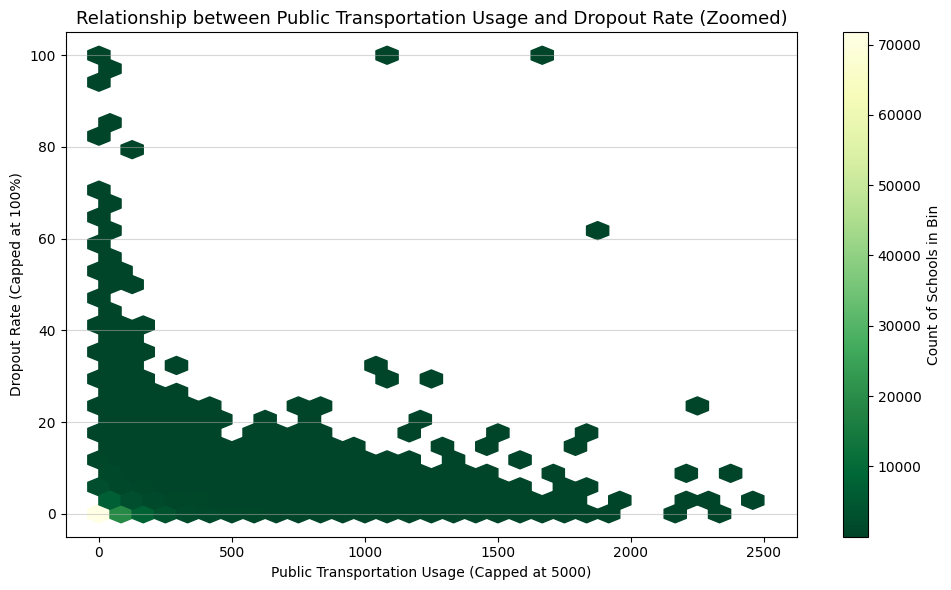

In [134]:
plot_hexbin_with_dropout(
  df_final,
  'QT_TRANSP_PUBLICO',
  'Relationship between Public Transportation Usage and Dropout Rate (Zoomed)',
  'Public Transportation Usage',
  max_feature_val=5000
)

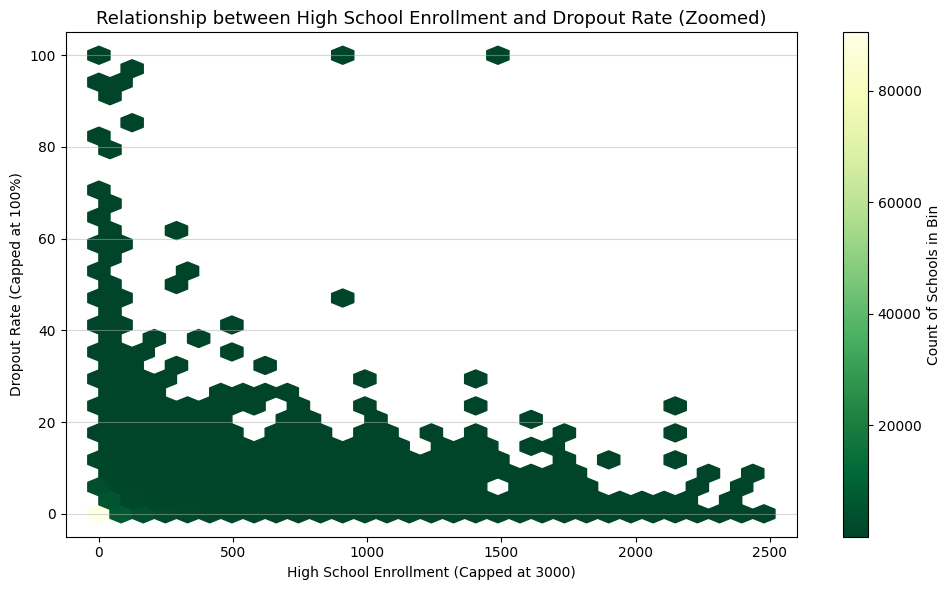

In [135]:
plot_hexbin_with_dropout(
  df_final,
  'QT_MAT_MED',
  'Relationship between High School Enrollment and Dropout Rate (Zoomed)',
  'High School Enrollment',
  max_feature_val=3000
)

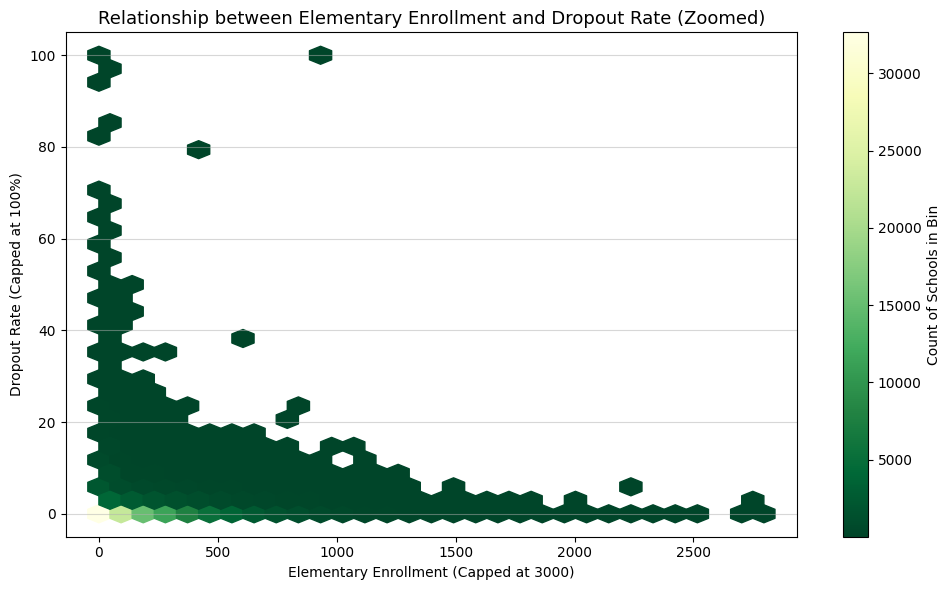

In [136]:
plot_hexbin_with_dropout(
  df_final,
  'QT_MAT_FUND',
  'Relationship between Elementary Enrollment and Dropout Rate (Zoomed)',
  'Elementary Enrollment',
  max_feature_val=3000
)

Group **Teachers and Classes Quantitative**

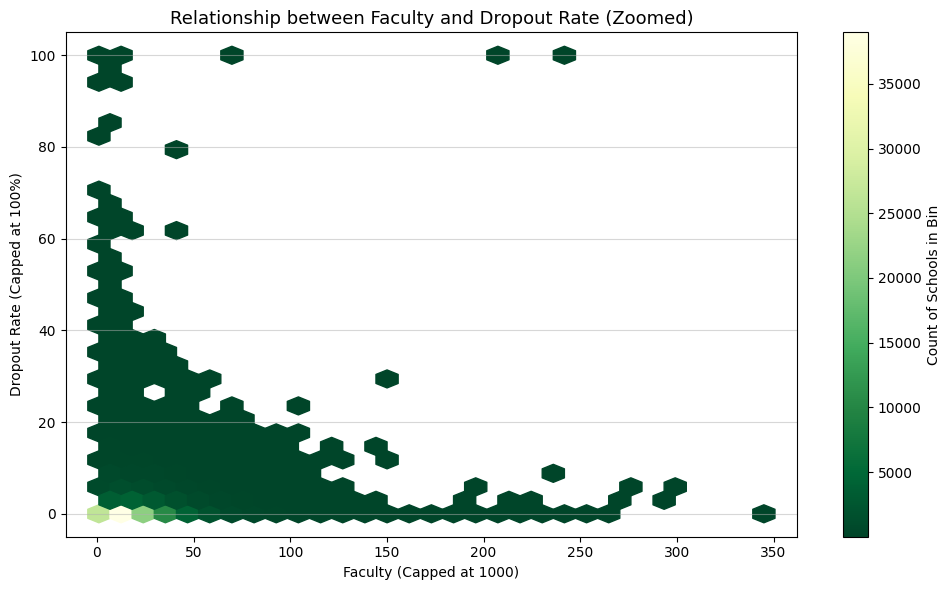

In [137]:
plot_hexbin_with_dropout(
  df_final,
  'QT_DOC_BAS',
  'Relationship between Faculty and Dropout Rate (Zoomed)',
  'Faculty'
)

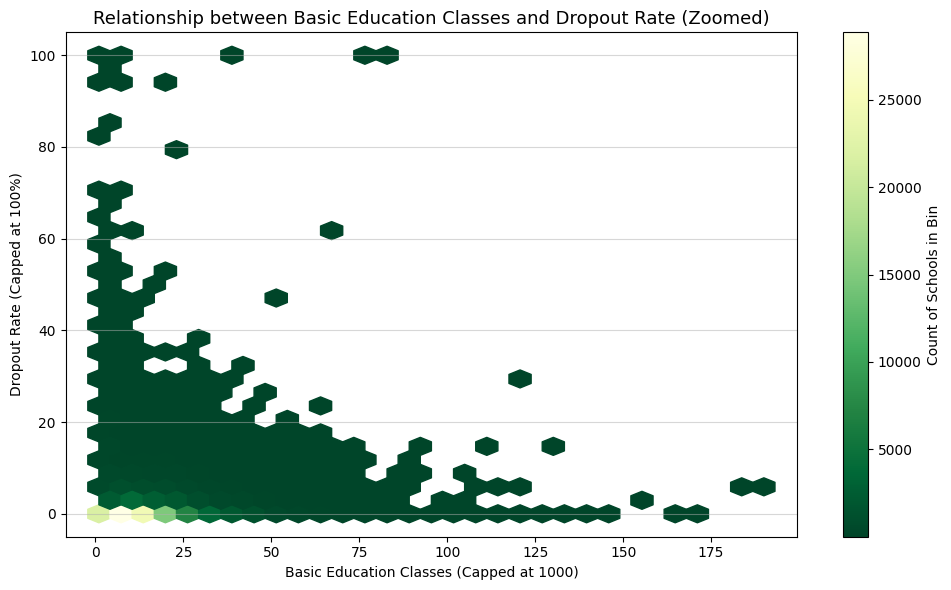

In [138]:
plot_hexbin_with_dropout(
  df_final,
  'QT_TUR_BAS',
  'Relationship between Basic Education Classes and Dropout Rate (Zoomed)',
  'Basic Education Classes'
)

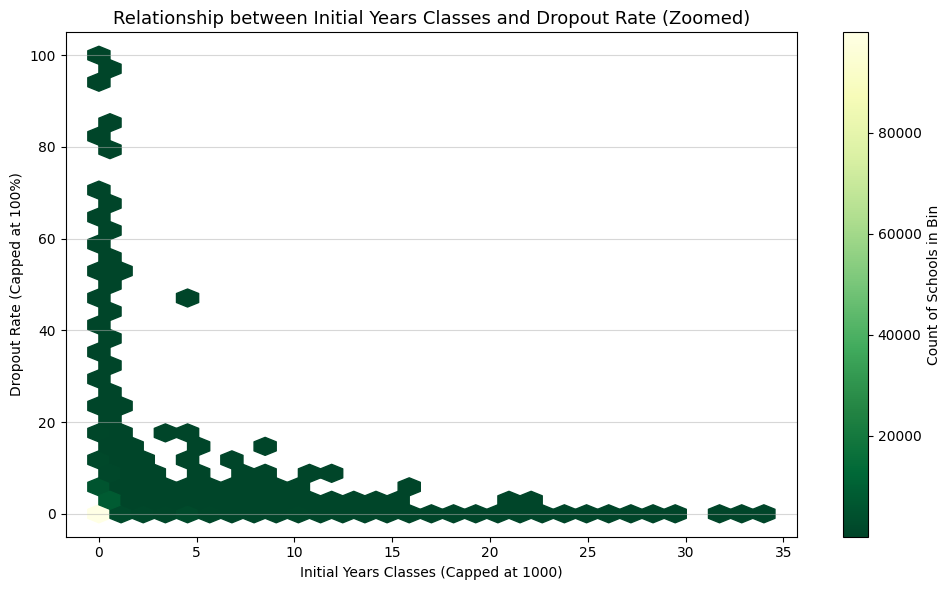

In [139]:
plot_hexbin_with_dropout(
  df_final,
  'QT_TUR_FUND_AI_INT',
  'Relationship between Initial Years Classes and Dropout Rate (Zoomed)',
  'Initial Years Classes'
)

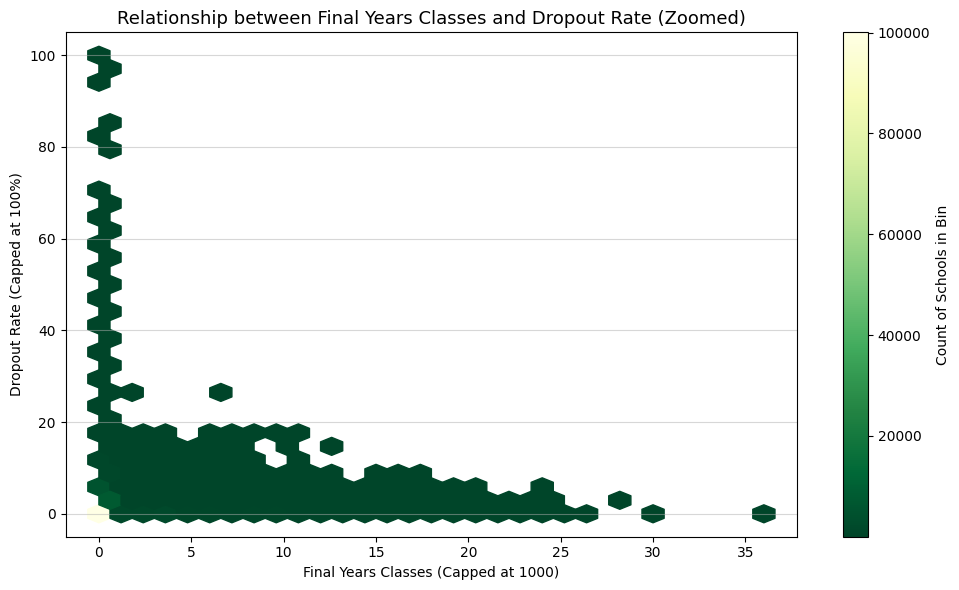

In [140]:
plot_hexbin_with_dropout(
  df_final,
  'QT_TUR_FUND_AF_INT',
  'Relationship between Final Years Classes and Dropout Rate (Zoomed)',
  'Final Years Classes'
)

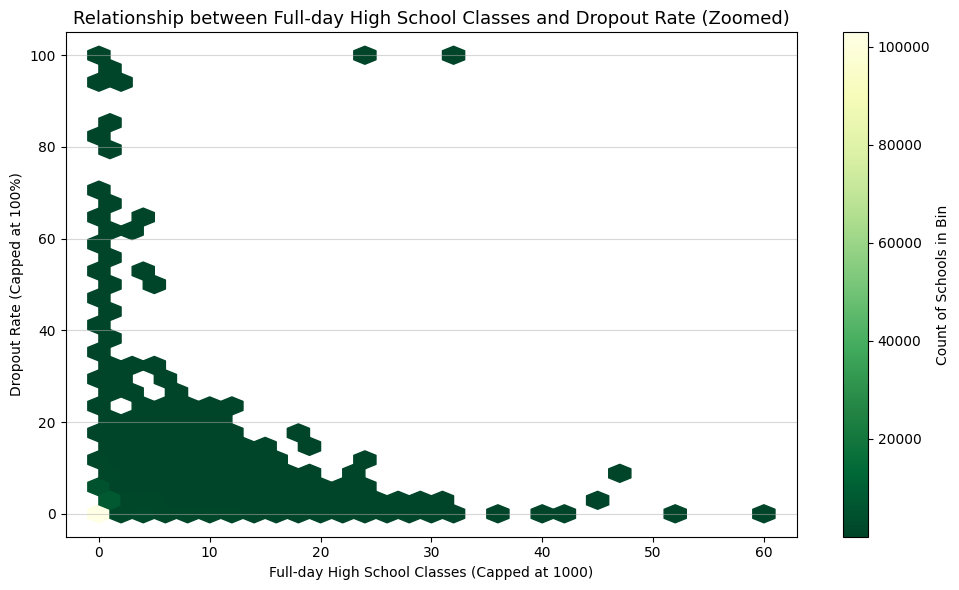

In [141]:
plot_hexbin_with_dropout(
  df_final,
  'QT_TUR_MED_INT',
  'Relationship between Full-day High School Classes and Dropout Rate (Zoomed)',
  'Full-day High School Classes'
)

## Splitting and Preprocessing

In [142]:
# Creating new target variable for classification problem
df_final_clf = df_final.copy()
df_final_clf['dropout'] = df_final[TARGET].apply(lambda x: 1 if x > 0 else 0)
df_final_clf.drop(TARGET, axis=1, inplace=True)

y = df_final_clf['dropout']
X = df_final_clf.drop('dropout', axis=1)

# Determine columns based on data types, excluding the target variable
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['float64', 'int64']).columns.tolist()

std_ftrs = numeric_cols
onehot_ftrs = categorical_cols

# Convert object and boolean columns to string type for One-Hot Encoder
for col in X.select_dtypes(include=['object', 'boolean']).columns:
    if col in onehot_ftrs:
        X[col] = X[col].astype(str)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

prep = Pipeline(steps=[('preprocessor', preprocessor)])

random_state = 42

X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,stratify=y,random_state=random_state)

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=random_state)
for fold, (train_index, val_index) in enumerate(kf.split(X_other,y_other)):
    print(f'Fold {fold+1}:')
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]

    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)

    feature_names_out = prep.named_steps['preprocessor'].get_feature_names_out()

    print(f'This fold presented: \n\
     - {X_train.shape[1]} features before preprocessing \n\
     - {X_train_prep.shape[1]} features after preprocessing \n\
     - {X_train.shape[0]} data points before preprocessing \n\
     - {X_train_prep.shape[0]} data points after preprocessing')

    print("\n Missing Value Analysis (X_train_prep) \n")

    # Fraction of data points with any missing values
    rows_with_missing = np.sum(np.isnan(X_train_prep).any(axis=1))
    fraction_rows_missing = rows_with_missing / X_train_prep.shape[0]
    print(f"Fraction of data points with any missing values: {fraction_rows_missing:.4f}")

    # Which features have missing values and their percentage
    missing_values_pct = np.mean(np.isnan(X_train_prep), axis=0) * 100
    features_with_missing_mask = missing_values_pct > 0

    print("\nPercentage of missing values per feature (for features with NaNs):")
    missing_feature_names = feature_names_out[features_with_missing_mask]
    missing_percentages = missing_values_pct[features_with_missing_mask]

    for name, pct in zip(missing_feature_names, missing_percentages):
        print(f"Feature '{name}': {pct:.2f}% missing")

    # Fraction of features that have missing values
    fraction_features_missing = np.sum(features_with_missing_mask) / X_train_prep.shape[1]
    print(f"\nFraction of features with missing values: {fraction_features_missing:.4f}")

    print("-" * 15)


Fold 1:
This fold presented: 
     - 345 features before preprocessing 
     - 1285 features after preprocessing 
     - 81090 data points before preprocessing 
     - 81090 data points after preprocessing

 Missing Value Analysis (X_train_prep) 

Fraction of data points with any missing values: 0.0000

Percentage of missing values per feature (for features with NaNs):

Fraction of features with missing values: 0.0000
---------------
Fold 2:
This fold presented: 
     - 345 features before preprocessing 
     - 1275 features after preprocessing 
     - 81090 data points before preprocessing 
     - 81090 data points after preprocessing

 Missing Value Analysis (X_train_prep) 

Fraction of data points with any missing values: 0.0000

Percentage of missing values per feature (for features with NaNs):

Fraction of features with missing values: 0.0000
---------------
Fold 3:
This fold presented: 
     - 345 features before preprocessing 
     - 1278 features after preprocessing 
     - 810